This is a Jupyter Notebook.

To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [1]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Edits Per Hour Example

_Tacloban, Philippines_

These next cells will load the output from the following query in Athena:

```sql
SELECT date_trunc('hour', updated), avg( date_diff('minute', updated, valid_until) ) AS avg_lifespan_minutes, count(distinct(changesets.uid)) AS num_users, count(*) AS edits, count(distinct(southeastern_asia.id)) AS objects
FROM southeastern_asia
JOIN changesets
    ON southeastern_asia.changeset = changesets.id
WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.980451 11.265362, 125.03352 11.265362, 125.03352 11.17746, 124.980451 11.17746, 124.980451 11.265362))') )
GROUP BY  date_trunc('hour', updated)
```

In [3]:
#Tacloban, Philippines by hour: 
tacloban = load_dataframe_from_s3('4c65e9b0-13fc-416b-bc40-12f7d70348b0')


/www/4c65e9b0-13fc-416b-bc40-12f7d70348b0.csv
Creating dataframe... done.  Found 1,320 rows

In [4]:
tacloban.head(2)

,_col0,avg_lifespan_minutes,num_users,edits,objects
0,2013-11-13 22:00:00.000,739188.866667,3,137,137
1,2013-11-08 11:00:00.000,14939.393496,4,618,615


In [5]:
#Rename the columns so they make more sense
tacloban.columns = ["date", "lifespan_minutes", "num_users", "edits", "objects"]

#Cast the date as date
tacloban['datetime'] = tacloban.date.apply(pd.Timestamp)

#Reindex (and sort)by date becuase the original query was organized that way
tacloban.set_index('datetime', inplace=True)
tacloban.sort_index(inplace=True)

#Add two new columns:
tacloban['lifespan_days'] = tacloban.lifespan_minutes.apply(lambda x: x/(60*24))
tacloban['object_percent'] = tacloban.objects / tacloban.objects.sum()

#Finally, show the new dataframe
tacloban.head(3)

,date,lifespan_minutes,num_users,edits,objects,lifespan_days,object_percent
datetime,,,,,,,
2007-03-04 01:00:00,2007-03-04 01:00:00.000,895960.0,1,1,1,622.194444,0.000012
2007-03-04 02:00:00,2007-03-04 02:00:00.000,895914.0,1,3,3,622.162500,0.000037
2007-03-04 03:00:00,2007-03-04 03:00:00.000,895840.0,1,1,1,622.111111,0.000012


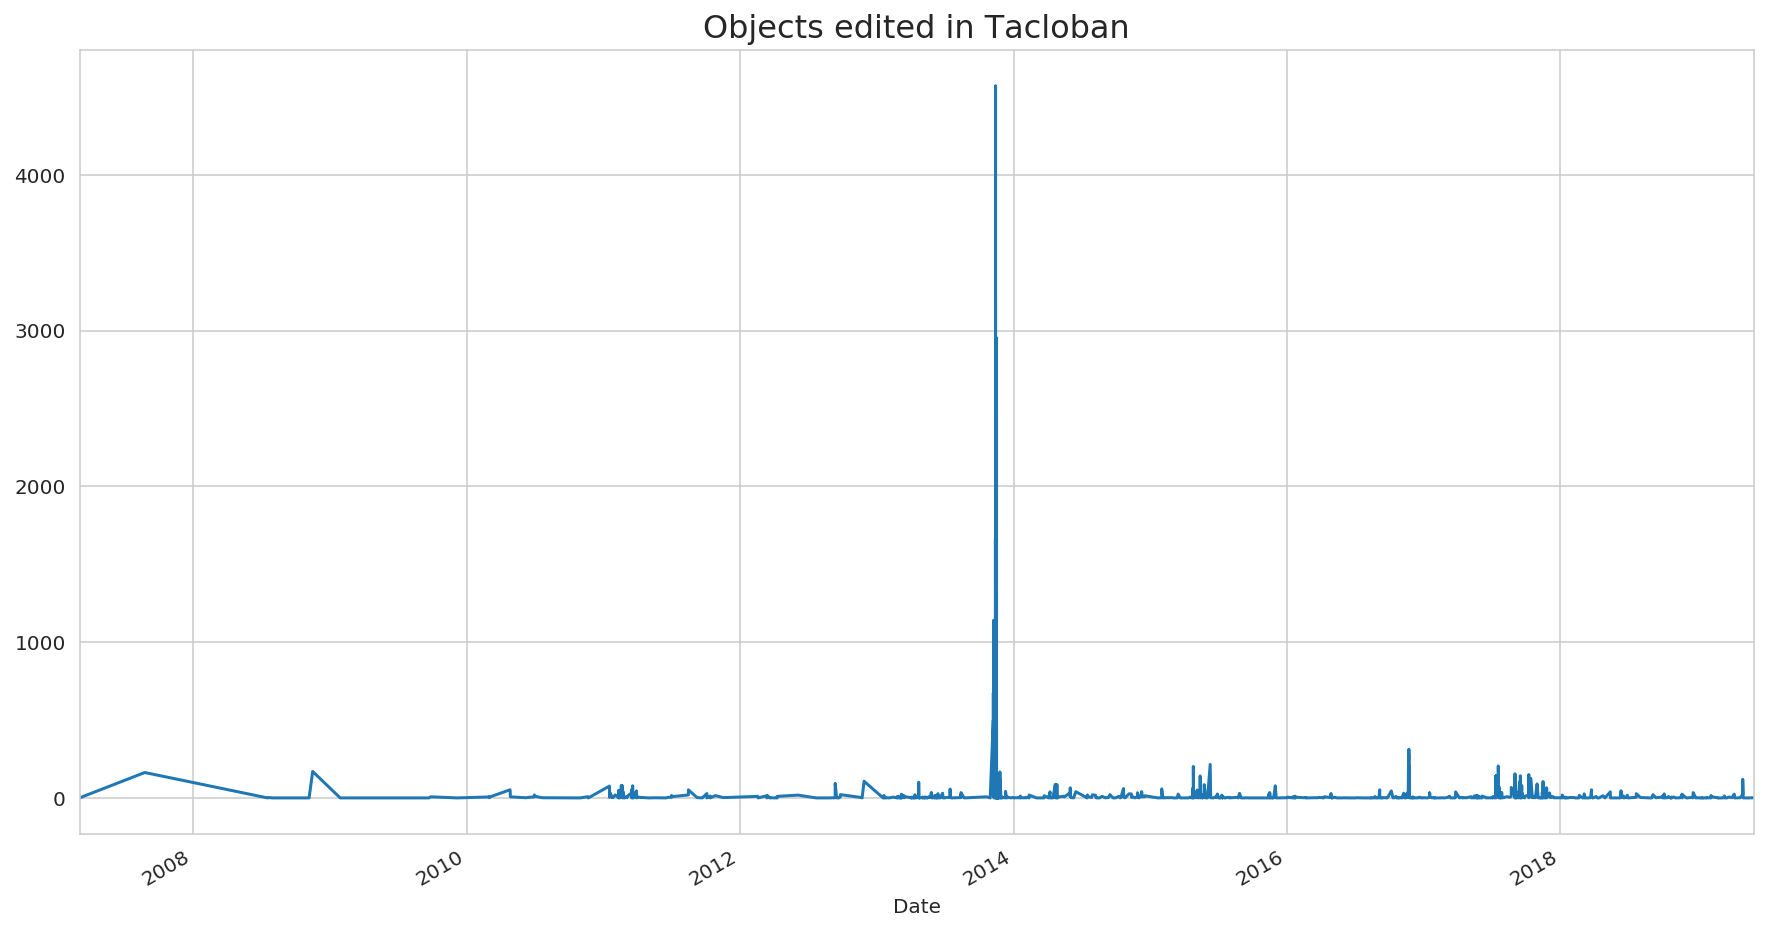

In [6]:
sns.set_style('whitegrid')
# fig, ax = plt.subplots(figsize=(15,7))
ax = tacloban['objects'].plot(figsize=(15,8))
ax.set_xlabel("Date"); ax.set_ylabel(""); 
ax.set_title("Objects edited in Tacloban",fontsize=16);

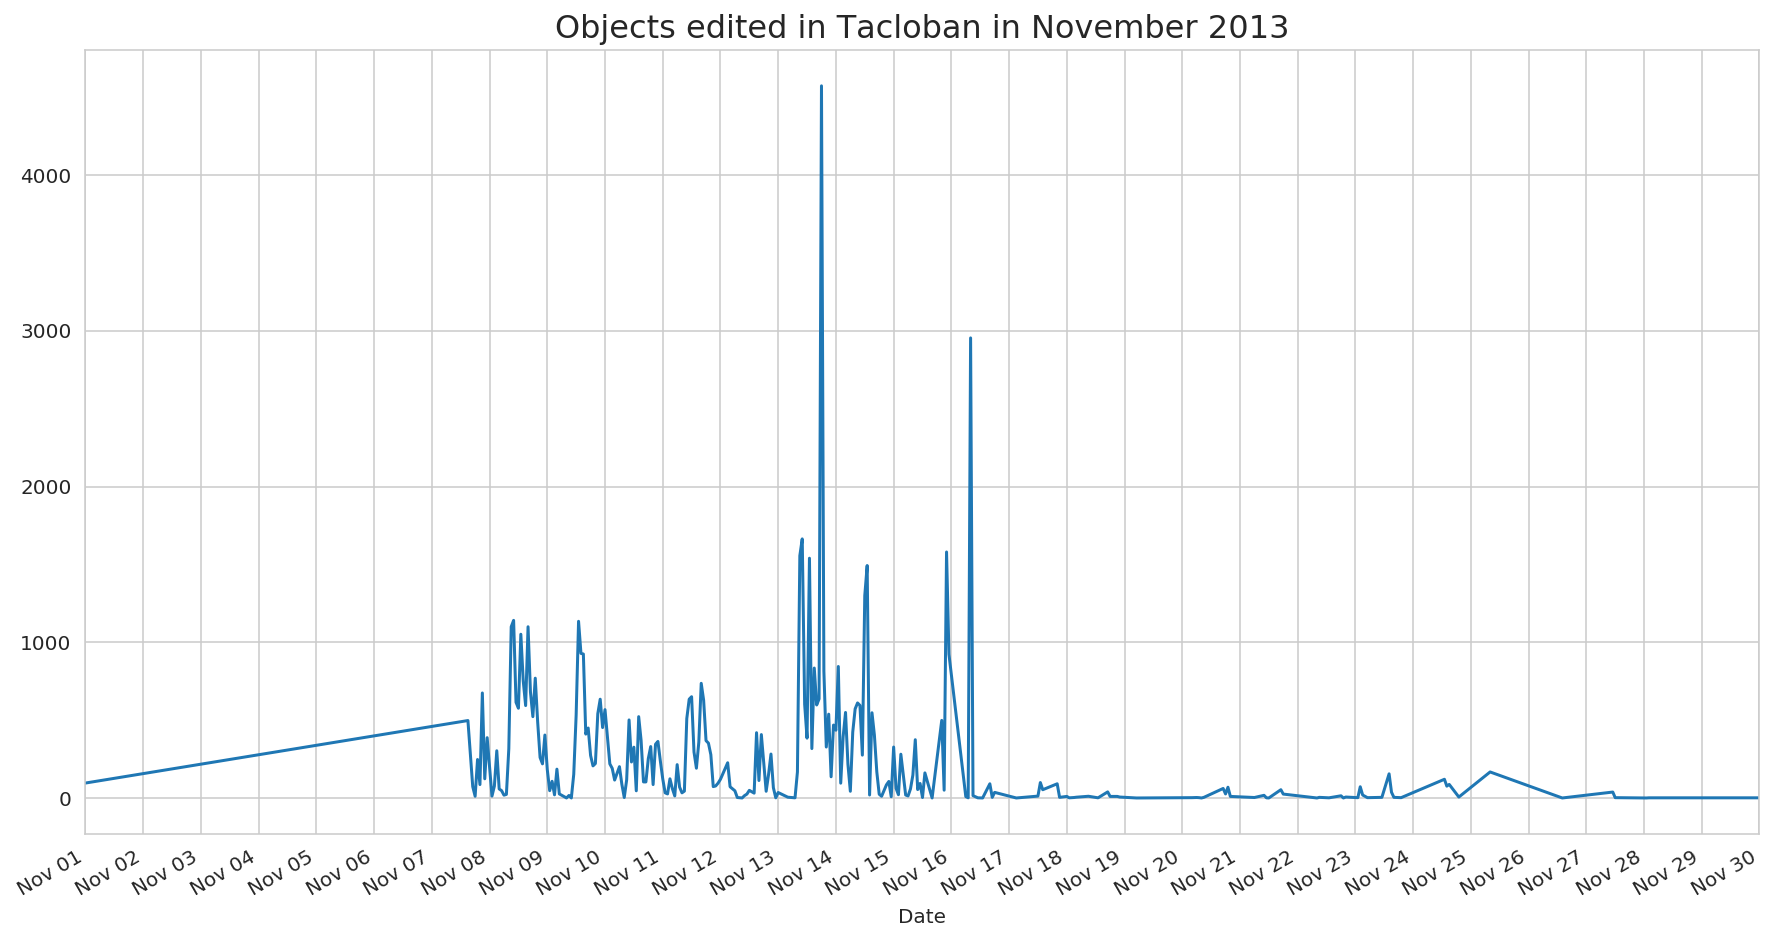

In [7]:
# Same plot, but zoom in on November 2013: 

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,7))
tacloban['objects'].plot(figsize=(15,8), ax=ax)
ax.set_xlabel("Date"); ax.set_ylabel(""); 
ax.set_title("Objects edited in Tacloban in November 2013",fontsize=16);
ax.set_xlim([datetime.date(2013,11,1), datetime.date(2013,11,30)])

#set ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

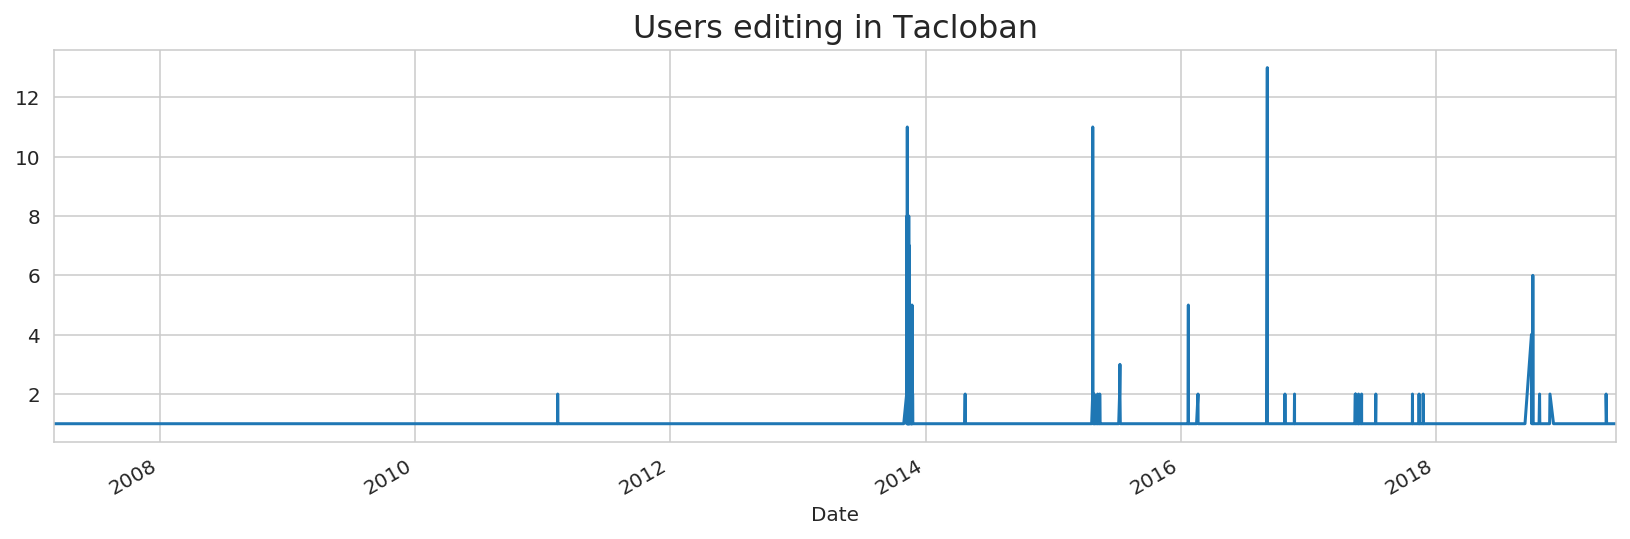

In [8]:
# How many users are editing the map here each day?
ax = tacloban['num_users'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Users editing in Tacloban",fontsize=16);
# ax.set_xlim([datetime.date(2013,11,1), datetime.date(2013,11,30)])


In [9]:
print("In total, the number of edits in Tacloban is: {:,}".format(tacloban.edits.sum()))

In total, the number of edits in Tacloban is: 83,550


## Again, retrieve all of the actual buildings from Athena 


```sql    
SELECT southeastern_asia.id AS id,
             southeastern_asia.type AS type,
             southeastern_asia.geom AS geom,
             southeastern_asia.tags AS b_tags,
             southeastern_asia.changeset,
             southeastern_asia.updated,
             southeastern_asia.valid_until,
             southeastern_asia.version,
             southeastern_asia.minor_version,
             changesets.id,
             changesets.uid,
             changesets.user,
             changesets.tags AS c_tags
    FROM southeastern_asia
    JOIN changesets
        ON southeastern_asia.changeset = changesets.id
    WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.980451 11.265362, 125.03352 11.265362, 125.03352 11.17746, 124.980451 11.17746, 124.980451 11.265362))') )
            AND element_at(southeastern_asia.tags, 'building') IS NOT NULL
```

In [32]:
buildings = load_dataframe_from_s3('6eceee06-c6df-44f2-a084-dee157c688cd')


Found file locally... Creating dataframe... done.  Found 70,663 rows

In [37]:
buildings['hour'] = buildings.updated.apply(pd.Timestamp)

In [38]:
buildings.head(2)

,id,type,geom,b_tags,changeset,updated,valid_until,version,minor_version,id.1,uid,user,c_tags,hour
0,245140304,2,"POLYGON ((125.0035281 11.246777, 125.0034795 1...","{source=Bing, building=yes}",18775906,2013-11-08 03:19:14.000,2013-11-13 18:26:21.000,1,0,18775906,214969,AndrewBuck,"{comment=Tracing buildings, created_by=JOSM/1....",2013-11-08 03:19:14
1,245468130,2,"POLYGON ((124.9926461 11.1954436, 124.9925171 ...","{typhoon:damage=yes, source=WorldView-2,Digita...",18928590,2013-11-16 08:38:49.000,NaN,3,0,18928590,81841,schadow1,{comment=Task 350 Building Damage Detection Br...,2013-11-16 08:38:49


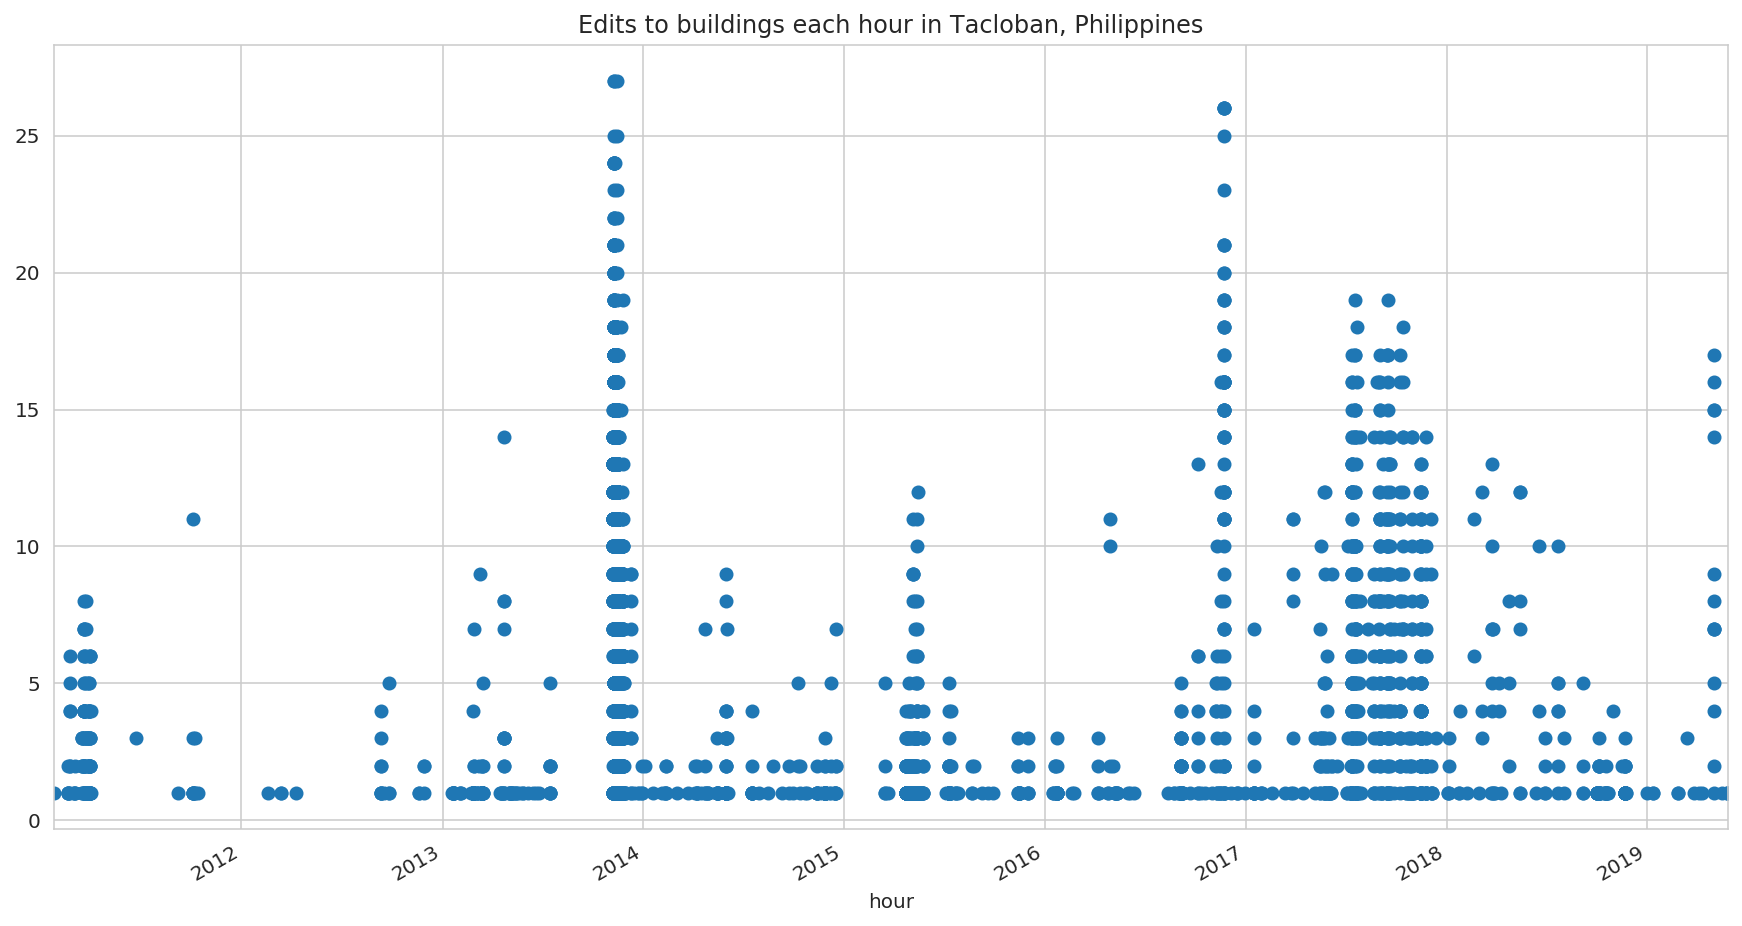

In [39]:
ax = buildings.groupby('hour').aggregate('count')['id'].plot(style="o", figsize=(15,8))
ax.set_title("Edits to buildings each hour in Tacloban, Philippines");

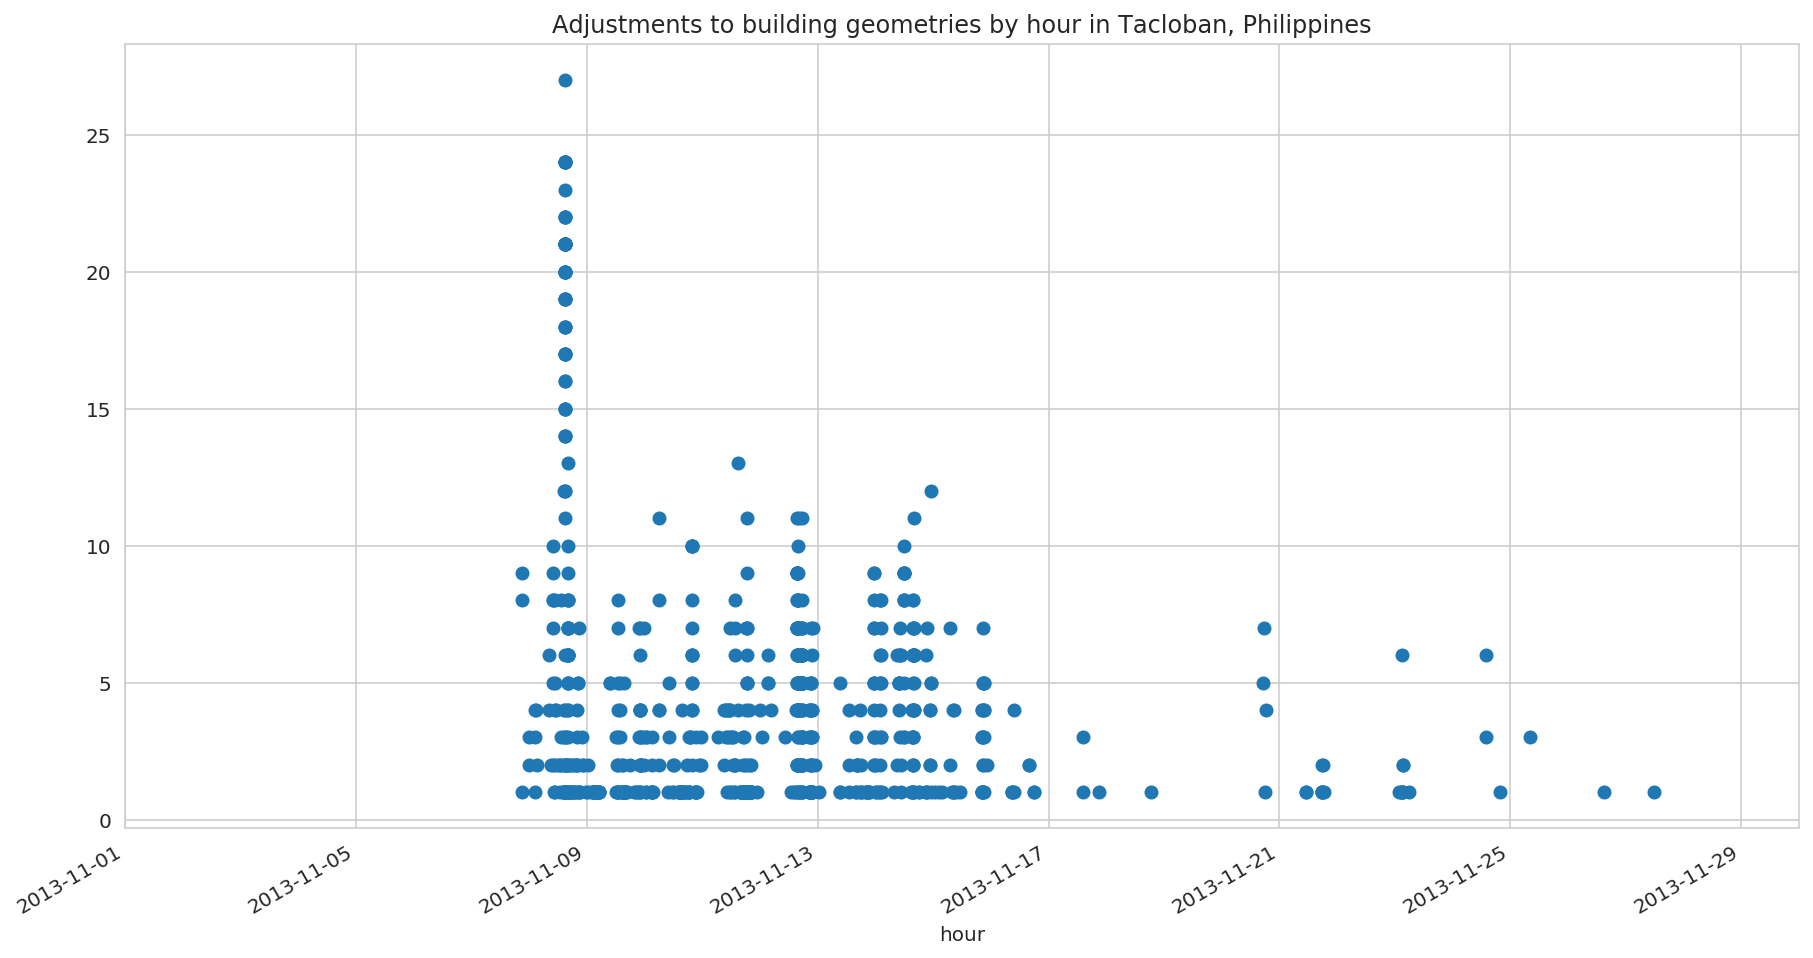

In [42]:
ax = buildings[buildings.minor_version>0].groupby('hour').aggregate('count')['id'].plot(style='o', figsize=(15,8))
ax.set_title("Adjustments to building geometries by hour in Tacloban, Philippines");
ax.set_xlim(datetime.datetime(2013,11,1),datetime.datetime(2013,11,30));


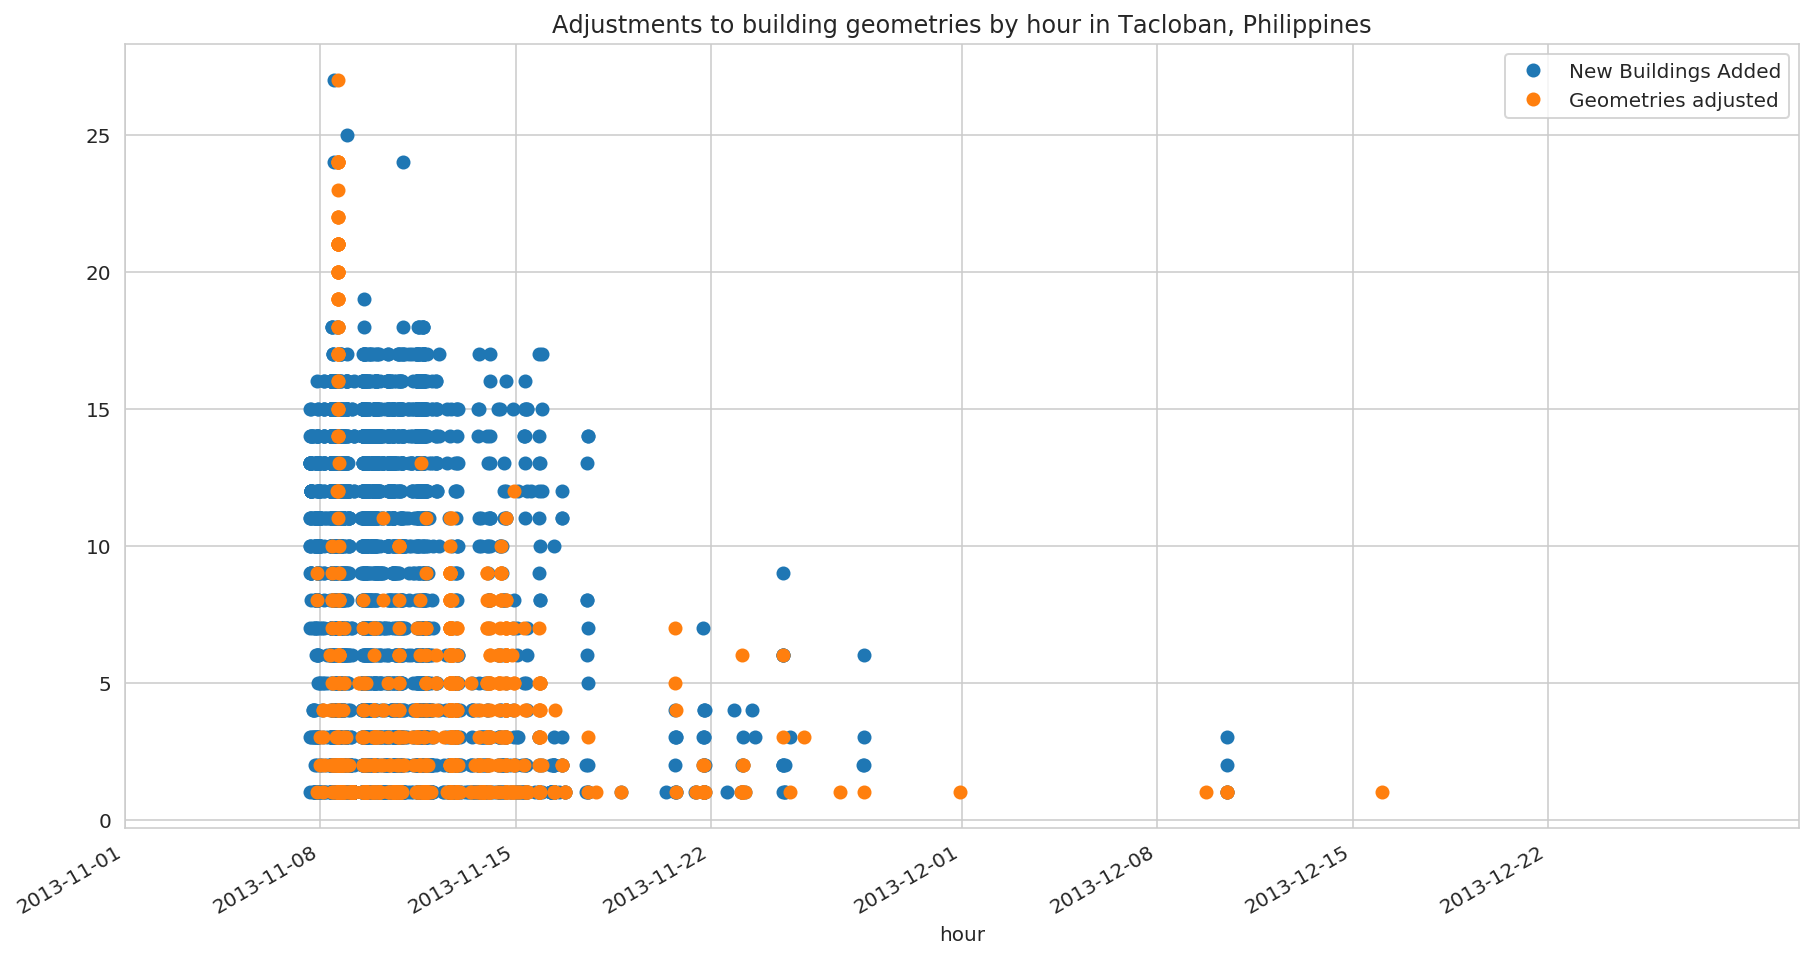

In [49]:
ax = buildings[(buildings.version==1) & (buildings.minor_version==0)].groupby(
    'hour').aggregate('count')['id'].plot(figsize=(15,8), style="o", label="New Buildings Added")
buildings[buildings.minor_version>0].groupby('hour').aggregate(
    'count')['id'].plot(style='o', figsize=(15,8), ax=ax, label="Geometries adjusted")
ax.set_title("Adjustments to building geometries by hour in Tacloban, Philippines");
ax.set_xlim(datetime.datetime(2013,11,1),datetime.datetime(2013,12,31))
ax.legend();